# A fuzzy approach to support decision-making in the triage processes  for suspected COVID-19 patients in Brazil

## Authors
* Nadya Regina Galo (nadyagalo@ufg.br) 
* Marcos Paulino Roriz Junior (marcosroriz@ufg.br)
* Rodrigo Pinheiro Tóffano Pereira (rodrigo_toffano@ufg.br)
----
* Faculty of Science and Technology
* Federal University of Goiás

<img src="logo.png" alt="FCT/UFG" width="300"/>

## Dependencies
* matplotlib, seaborn, pandas, numpy, **scikit-fuzzy**

## Data Source
* https://coronavirus.es.gov.br/painel-covid-19-es

# Preamble

In [1]:
# Jupyter Imports
import warnings
from IPython.display import SVG
from IPython.display import display

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Basic Imports
import pandas as pd
import numpy as np

In [3]:
# Graphical Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import PercentFormatter

sns.reset_defaults()
sns.reset_orig()
sns.set_palette("Set2", 8)
sns.color_palette("Set2")
rc('font', **{"size": 12})

In [4]:
# Fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Reading Input Data

In [5]:
rawdf = pd.read_csv("MICRODADOS.csv", error_bad_lines=False, sep=";", encoding="iso-8859-1")
rawdf.head()

,DataNotificacao,DataCadastro,DataDiagnostico,DataColeta_RT_PCR,DataColetaTesteRapido,DataColetaSorologia,DataColetaSorologiaIGG,DataEncerramento,DataObito,Classificacao,...,ViagemBrasil,ViagemInternacional,ProfissionalSaude,PossuiDeficiencia,MoradorDeRua,ResultadoRT_PCR,ResultadoTesteRapido,ResultadoSorologia,ResultadoSorologia_IGG,TipoTesteRapido
0,2021-07-09,2021-06-19,2021-07-06,NaN,2021-07-09,NaN,NaN,2021-07-09,NaN,Descartados,...,Não,Não Informado,Não,Não,Não,Não Informado,Negativo,Não Informado,Não Informado,Teste rápido Antígeno
1,2021-07-09,2021-04-28,2021-07-09,NaN,2021-07-09,NaN,NaN,NaN,NaN,Confirmados,...,Não Informado,Não Informado,Não,Sim,Não,Não Informado,Positivo,Não Informado,Não Informado,Teste rápido Antígeno
2,2021-07-09,2021-07-06,2021-07-06,2021-07-09,NaN,NaN,NaN,2021-07-09,NaN,Descartados,...,Não Informado,Não Informado,Não,Não,Não,Negativo,Não Informado,Não Informado,Não Informado,Não Informado
3,2021-07-09,2021-04-29,2021-07-06,NaN,2021-07-09,NaN,NaN,NaN,NaN,Confirmados,...,Não Informado,Não Informado,Não,Não,Não,Não Informado,Positivo,Não Informado,Não Informado,Teste rápido Antígeno
4,2021-07-09,2021-07-09,2021-07-06,2021-07-09,NaN,NaN,NaN,NaN,NaN,Suspeito,...,Não Informado,Não Informado,Não,Não,Não,Não Informado,Não Informado,Não Informado,Não Informado,Não Informado


In [6]:
# Number of records
rawdf.shape

(1679329, 45)

In [7]:
# Removing none responses
df = rawdf
df = df[df["Febre"] != "-"]
df = df[df["DificuldadeRespiratoria"] != "-"]
df = df[df["Tosse"] != "-"]
df = df[df["Coriza"] != "-"]
df = df[df["DorGarganta"] != "-"]
df = df[df["Diarreia"] != "-"]
df = df[df["Cefaleia"] != "-"]
df = df[df["ComorbidadePulmao"] != "-"]
df = df[df["ComorbidadeCardio"] != "-"]
df = df[df["ComorbidadeRenal"] != "-"]
df = df[df["ComorbidadeDiabetes"] != "-"]
df = df[df["ComorbidadeObesidade"] != "-"]
df = df[df["FicouInternado"] != "-"]

# Preprocessing input variables

## Vital Signs

In [8]:
# Febre = Fever
df["Febre"].value_counts()

Não    1134433
Sim     540919
Name: Febre, dtype: int64

In [9]:
# VS - Vital Signs
# Sim = Yes
def sv(row):
    if row["Febre"] == "Sim":
        return 2
    else:
        return 0

df["VS"] = df.apply(sv, axis=1)
df["VS"].value_counts()

0    1134433
2     540919
Name: VS, dtype: int64

## Breathing Difficulty

In [10]:
# Dificuldade Respiratória = Breathing Difficulty
df["DificuldadeRespiratoria"].value_counts()

Não    1456989
Sim     218363
Name: DificuldadeRespiratoria, dtype: int64

In [11]:
# BD - Breathing Difficulty
def bd(row):
    if row["DificuldadeRespiratoria"] == "Sim":
        return 0.5
    else:
        return 0

df["BD"] = df.apply(bd, axis=1)
df["BD"].value_counts()

0.0    1456989
0.5     218363
Name: BD, dtype: int64

## Risk Factors

In [12]:
# Age Group
df["FaixaEtaria"].value_counts()

30 a 39 anos       399119
20 a 29 anos       332774
40 a 49 anos       313720
50 a 59 anos       208304
10 a 19 anos       126743
60 a 69 anos       117267
0 a 4 anos          61014
70 a 79 anos        49905
05 a 9 anos         39240
80 a 89 anos        21854
90 anos ou mais      5353
-                      59
Name: FaixaEtaria, dtype: int64

In [13]:
# Pregnant?
df["Gestante"].value_counts()

Não                           904668
Não se aplica                 755122
3º trimeste                     5941
Ignorado                        4321
2º trimeste                     2652
1º trimeste                     2123
Idade gestacional ignorada       525
Name: Gestante, dtype: int64

In [14]:
def rf(row):
    if (row["FaixaEtaria"] == "60 a 69 anos" or 
        row["FaixaEtaria"] == "70 a 79 anos" or
        row["FaixaEtaria"] == "80 a 89 anos" or
        row["FaixaEtaria"] == "90 anos ou mais" or
        row["ComorbidadePulmao"] == "Sim" or
        row["ComorbidadeCardio"] == "Sim" or
        row["ComorbidadeRenal"] == "Sim" or 
        row["ComorbidadeDiabetes"] == "Sim" or
        row["ComorbidadeTabagismo"] == "Sim" or 
        row["ComorbidadeObesidade"] == "Sim" or
        row["Gestante"] == "1º trimeste" or
        row["Gestante"] == "2º trimeste" or
        row["Gestante"] == "3º trimeste"):
        return 1
    else:
        return 0

df["RF"] = df.apply(rf, axis=1)
df["RF"].value_counts()

0    1280225
1     395127
Name: RF, dtype: int64

## Other Relevant Syntoms

In [15]:
# RS - Relevant Syntoms
# Tosse = Cough
# Coriza = Runny nose
# Dor Garganta = Sore throat
# Diarreia = Diarrhea
# Cefaleia = Headache
def rs(row):
    if (row["Tosse"] == "Sim" or
        row["Coriza"] == "Sim" or
        row["DorGarganta"] == "Sim" or
        row["Diarreia"] == "Sim" or
        row["Cefaleia"] == "Sim"):
        return 1
    else:
        return 0

df["RS"] = df.apply(rs, axis=1)
df["RS"].value_counts()

1    1209767
0     465585
Name: RS, dtype: int64

# Fuzzy Model

## Variables and Membership

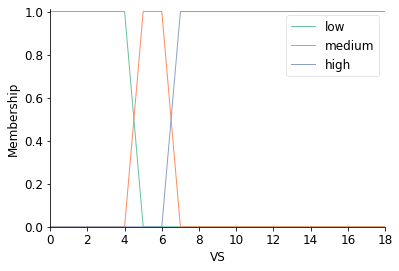

In [16]:
fuzzy_vs = ctrl.Antecedent(np.arange(0, 19, 1), 'VS')

fuzzy_vs["low"] = fuzz.trapmf(fuzzy_vs.universe, [0, 0, 4, 5])
fuzzy_vs['medium'] = fuzz.trapmf(fuzzy_vs.universe, [4, 5, 6, 7])
fuzzy_vs['high'] = fuzz.trapmf(fuzzy_vs.universe, [6, 7, 18, 18])
fuzzy_vs.view()

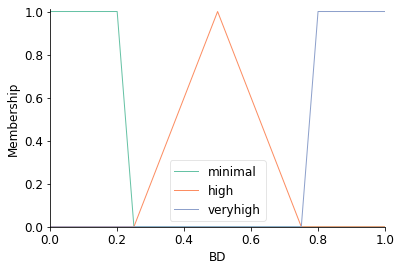

In [17]:
fuzzy_bd = ctrl.Antecedent(np.arange(0, 1.01, 0.05), 'BD')

fuzzy_bd["minimal"] = fuzz.trapmf(fuzzy_bd.universe, [0, 0, 0.2, 0.25])
fuzzy_bd['high'] = fuzz.trimf(fuzzy_bd.universe, [0.25, 0.5, 0.75])
fuzzy_bd['veryhigh'] = fuzz.trapmf(fuzzy_bd.universe, [0.75, 0.8, 1, 1])
fuzzy_bd.view()

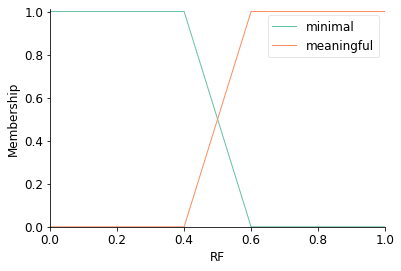

In [18]:
fuzzy_rf = ctrl.Antecedent(np.arange(0, 1.01, 0.05), 'RF')

fuzzy_rf["minimal"] = fuzz.trapmf(fuzzy_rf.universe, [0, 0, 0.4, 0.6])
fuzzy_rf['meaningful'] = fuzz.trapmf(fuzzy_rf.universe, [0.4, 0.6, 1, 1])
fuzzy_rf.view()

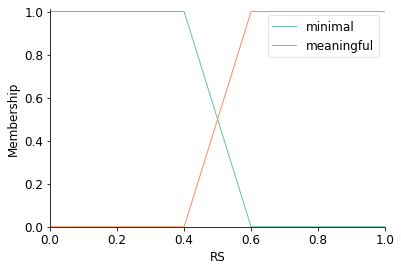

In [19]:
fuzzy_rs = ctrl.Antecedent(np.arange(0, 1.01, 0.05), 'RS')

fuzzy_rs["minimal"] = fuzz.trapmf(fuzzy_rs.universe, [0, 0, 0.4, 0.6])
fuzzy_rs['meaningful'] = fuzz.trapmf(fuzzy_rs.universe, [0.4, 0.6, 1, 1])
fuzzy_rs.view()

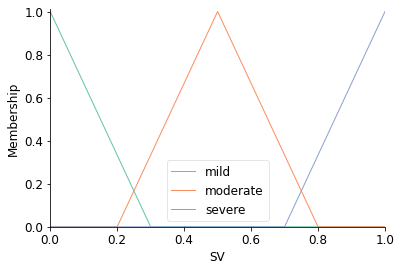

In [20]:
fuzzy_sv = ctrl.Consequent(np.arange(0, 1.01, 0.05), 'SV', defuzzify_method="centroid")

fuzzy_sv["mild"] = fuzz.trimf(fuzzy_sv.universe, [0, 0, 0.3])
fuzzy_sv['moderate'] = fuzz.trimf(fuzzy_sv.universe, [0.2, 0.5, 0.8])
fuzzy_sv['severe'] = fuzz.trimf(fuzzy_sv.universe, [0.7, 1, 1])
fuzzy_sv.view()

## Control

In [21]:
r1  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["minimal"]  & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["mild"])
r2  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["minimal"]  & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["mild"])
r3  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["minimal"]  & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["mild"])
r4  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["minimal"]  & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r5  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["high"]     & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["moderate"])
r6  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["high"]     & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r7  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["high"]     & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r8  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["high"]     & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r9  = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["veryhigh"] & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r10 = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["veryhigh"] & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r11 = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["veryhigh"] & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r12 = ctrl.Rule(fuzzy_vs['low']    & fuzzy_bd["veryhigh"] & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])

r13 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["minimal"]  & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["mild"])
r14 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["minimal"]  & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["moderate"])
r15 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["minimal"]  & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["moderate"])
r16 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["minimal"]  & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["moderate"])
r17 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["high"]     & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["moderate"])
r18 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["high"]     & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r19 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["high"]     & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r20 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["high"]     & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r21 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["veryhigh"] & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r22 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["veryhigh"] & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r23 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["veryhigh"] & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r24 = ctrl.Rule(fuzzy_vs['medium'] & fuzzy_bd["veryhigh"] & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])


r25 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["minimal"]  & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["moderate"])
r26 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["minimal"]  & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r27 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["minimal"]  & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r28 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["minimal"]  & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r29 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["high"]     & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r30 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["high"]     & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r31 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["high"]     & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r32 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["high"]     & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r33 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["veryhigh"] & fuzzy_rf["minimal"]    & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r34 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["veryhigh"] & fuzzy_rf["minimal"]    & fuzzy_rs["meaningful"], fuzzy_sv["severe"])
r35 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["veryhigh"] & fuzzy_rf["meaningful"] & fuzzy_rs["minimal"],    fuzzy_sv["severe"])
r36 = ctrl.Rule(fuzzy_vs['high']   & fuzzy_bd["veryhigh"] & fuzzy_rf["meaningful"] & fuzzy_rs["meaningful"], fuzzy_sv["severe"])

In [22]:
fuzzy_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12,
                                 r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24,
                                 r25, r26, r27, r28, r29, r30, r31, r32, r33, r34, r35, r36 ])

In [23]:
fuzzy_system = ctrl.ControlSystemSimulation(fuzzy_ctrl)

## Sample Execution

In [24]:
fuzzy_system.input['VS'] = 2
fuzzy_system.input['BD'] = 0.5
fuzzy_system.input['RF'] = 1
fuzzy_system.input['RS'] = 1
fuzzy_system.compute()
fuzzy_system.output

OrderedDict([('SV', 0.9000000000000001)])

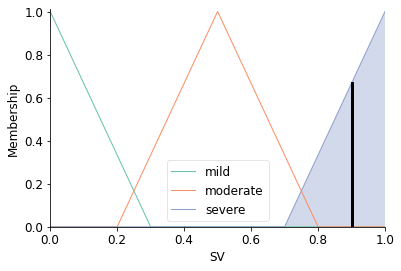

In [25]:
fuzzy_sv.view(sim=fuzzy_system)

# Apply to the dataset

In [26]:
def fuzzify(row):
    fuzzy_system.input['VS'] = row["VS"]
    fuzzy_system.input['BD'] = row["BD"]
    fuzzy_system.input['RF'] = row["RF"]
    fuzzy_system.input['RS'] = row["RS"]
    fuzzy_system.compute()
    return fuzzy_system.output["SV"]


In [27]:
df["FUZZY"] = df.apply(fuzzify, axis=1)
df["FUZZY"].value_counts()

0.1    1216806
0.9     449412
0.5       9134
Name: FUZZY, dtype: int64

In [28]:
df["FUZZYSTR"] = np.where(df["FUZZY"] >= 0.75, "Sim", "Não")
df["FUZZYSTR"].value_counts(normalize=True)

Não    0.731751
Sim    0.268249
Name: FUZZYSTR, dtype: float64

# Plot

In [29]:
def plotComparison(df_fuzzy, df_manual, ax):
    labels = ["Yes", "No"]
    
    df_fuzzy_yes  = 0
    df_fuzzy_no   = 0
    df_manual_yes = 0
    df_manual_no  = 0
    
    if "Sim" in df_fuzzy.index:
        df_fuzzy_yes = df_fuzzy.loc["Sim"]["percentage"]
    
    if "Não" in df_fuzzy.index:
        df_fuzzy_no = df_fuzzy.loc["Não"]["percentage"]

    if "Sim" in df_manual.index:
        df_manual_yes = df_manual.loc["Sim"]["percentage"]
    
    if "Não" in df_manual.index:
        df_manual_no = df_manual.loc["Não"]["percentage"]
    
    data_yes = [df_fuzzy_yes, df_fuzzy_no]
    data_no = [df_manual_yes, df_manual_no]

    x = np.arange(len(labels))  
    width = 0.3  # the width of the bars

    rects1 = ax.bar(x - width/2, data_yes, width, label='Yes')
    rects2 = ax.bar(x + width/2, data_no, width, label='No')

    return ax

In [30]:
def processData(indf, column):
    outdf = indf[indf["Evolucao"] == column]
    outdf = outdf[(df["FicouInternado"] == "Sim") | (df["FicouInternado"] == "Não")]

    a = outdf["FUZZYSTR"].value_counts(normalize=True)
    b = outdf["FUZZYSTR"].value_counts()
    df_fuzzy = pd.concat([a, b], axis=1)
    df_fuzzy.columns = ["percentage", "raw"]

    a = outdf["FicouInternado"].value_counts(normalize=True)
    b = outdf["FicouInternado"].value_counts()
    df_manual = pd.concat([a, b], axis=1)
    df_manual.columns = ["percentage", "raw"]
    
    return df_fuzzy, df_manual

In [31]:
def putLabels(ax, xticks, label, addYLabel=True):
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # print(x, y, width, height)
        label_x = x + width - 0.04 # adjust 0.2 to center the label
        label_y = y + height + 0.04

        if (label_y > 1):
            label_y = label_y - 0.1
        
        # The width of the bar is the data value and can used as the label
        label_text = str(round(height * 100)) + "%"
        ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=12)
    
    if addYLabel:
        ax.set_ylabel('Percentage')
    
    ax.set_xlabel(label)
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_xticklabels(xticks)
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    ax.set_ylim(0, 1)


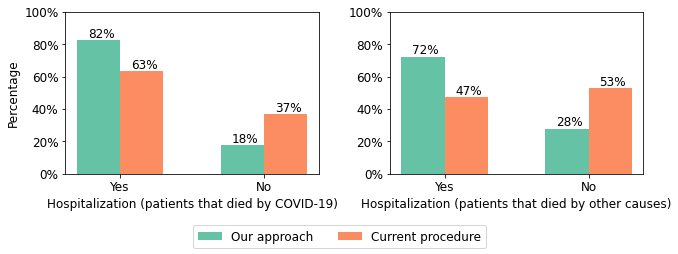

In [32]:
# Graph related to all cases in the state
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax0, ax1 = ax.flatten()
ylabels=["Our approach", "Current procedure"]
xlabels=["Yes", "No"]
df_fuzzy, df_manual = processData(df, "Óbito pelo COVID-19")
plotComparison(df_fuzzy, df_manual, ax0)
putLabels(ax0, xlabels, "Hospitalization (patients that died by COVID-19)")

df_fuzzy, df_manual = processData(df, "Óbito por outras causas")
plotComparison(df_fuzzy, df_manual, ax1)
putLabels(ax1, xlabels, "Hospitalization (patients that died by other causes)", False)

lgd = fig.legend(ax0, labels=ylabels, ncol=4, loc='lower center', bbox_transform = plt.gcf().transFigure)
fig.tight_layout(w_pad=2.5, h_pad=1, pad=3.5)

for lh in lgd.legendHandles: 
    lh.set_alpha(1)

fig.savefig('fig6.png', bbox_inches='tight', dpi=300)

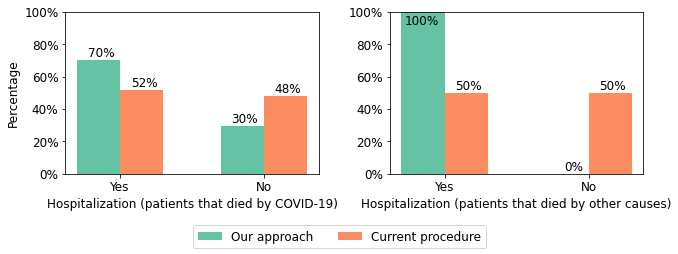

In [33]:
# Graph related to cases in Vila Valério

casedf = df[df["Municipio"] == "VILA VALERIO"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax0, ax1 = ax.flatten()
ylabels=["Our approach", "Current procedure"]
xlabels=["Yes", "No"]
df_fuzzy, df_manual = processData(casedf, "Óbito pelo COVID-19")
plotComparison(df_fuzzy, df_manual, ax0)
putLabels(ax0, xlabels, "Hospitalization (patients that died by COVID-19)")

df_fuzzy, df_manual = processData(casedf, "Óbito por outras causas")
plotComparison(df_fuzzy, df_manual, ax1)
putLabels(ax1, xlabels, "Hospitalization (patients that died by other causes)", False)

lgd = fig.legend(ax0, labels=ylabels, ncol=4, loc='lower center', bbox_transform = plt.gcf().transFigure)
fig.tight_layout(w_pad=2.5, h_pad=1, pad=3.5)

for lh in lgd.legendHandles: 
    lh.set_alpha(1)

fig.savefig('fig7.png', bbox_inches='tight', dpi=300)
